# Investigating well position effect: Scenario 2
**Author:** Jessica Ewald <br>

The purpose of this notebook is to quantify well position effect using two plates with 48X repeated ALK WT and one ALK VAR (a positive control). Previously, classifiers were constructed between cells in each WT versus each VAR well pair, between each possible pair of VAR wells and each possible pair of WT pairs. The WT-WT and VAR-VAR comparisons can be interrogated to get an estimate of well position effect across different positions. The WT-VAR comparisons will give an idea of the size of the morphological perturbation relative to the well position effect. 

In scenario 2, models were trained with cells from one plate and tested with cells from the other.

In [65]:
# Imports
import pathlib
import polars as pl
import pandas as pd
import numpy as np
from scipy import stats
import os
import seaborn as sns
import matplotlib.pyplot as plt

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

import warnings
warnings.filterwarnings("ignore")

In [66]:
result_dir = pathlib.Path(f'/dgx1nas1/storage/data/jess/varchamp/sc_data/classification_results/Rep_Ctrls_scen2')
batch = 'Rep_Ctrls_scen2'
feature_sets = ['non_protein', 'protein']

In [67]:
# Read in all F1 score and plot
comparisons = ['REF_control_f1score', 'VAR_control_f1score', 'f1score']
comp_dict = {'REF_control_f1score': 'REF_REF',
             'VAR_control_f1score': 'VAR_VAR',
             'f1score': 'REF_VAR'}

f1_score = pl.DataFrame()
for fs in feature_sets:
    for comp in comparisons:
        
        df = pl.read_csv(f'{result_dir}/{batch}_{fs}_{comp}_normalized_feature_selected.csv')
        
        if "Reference_Well" in df.columns:
            df = df.rename({"Reference_Well": "Well_One", "Variant_Well": "Well_Two"})
            
        df = df.melt(id_vars = ['Well_One', 'Well_Two']).with_columns(pl.lit(fs).alias("Feature_Set"),
                                                                      pl.lit(comp_dict[comp]).alias('Comparison'),
                                                                      pl.lit(batch).alias('Batch'))
        f1_score = pl.concat([f1_score, df], how = "vertical")

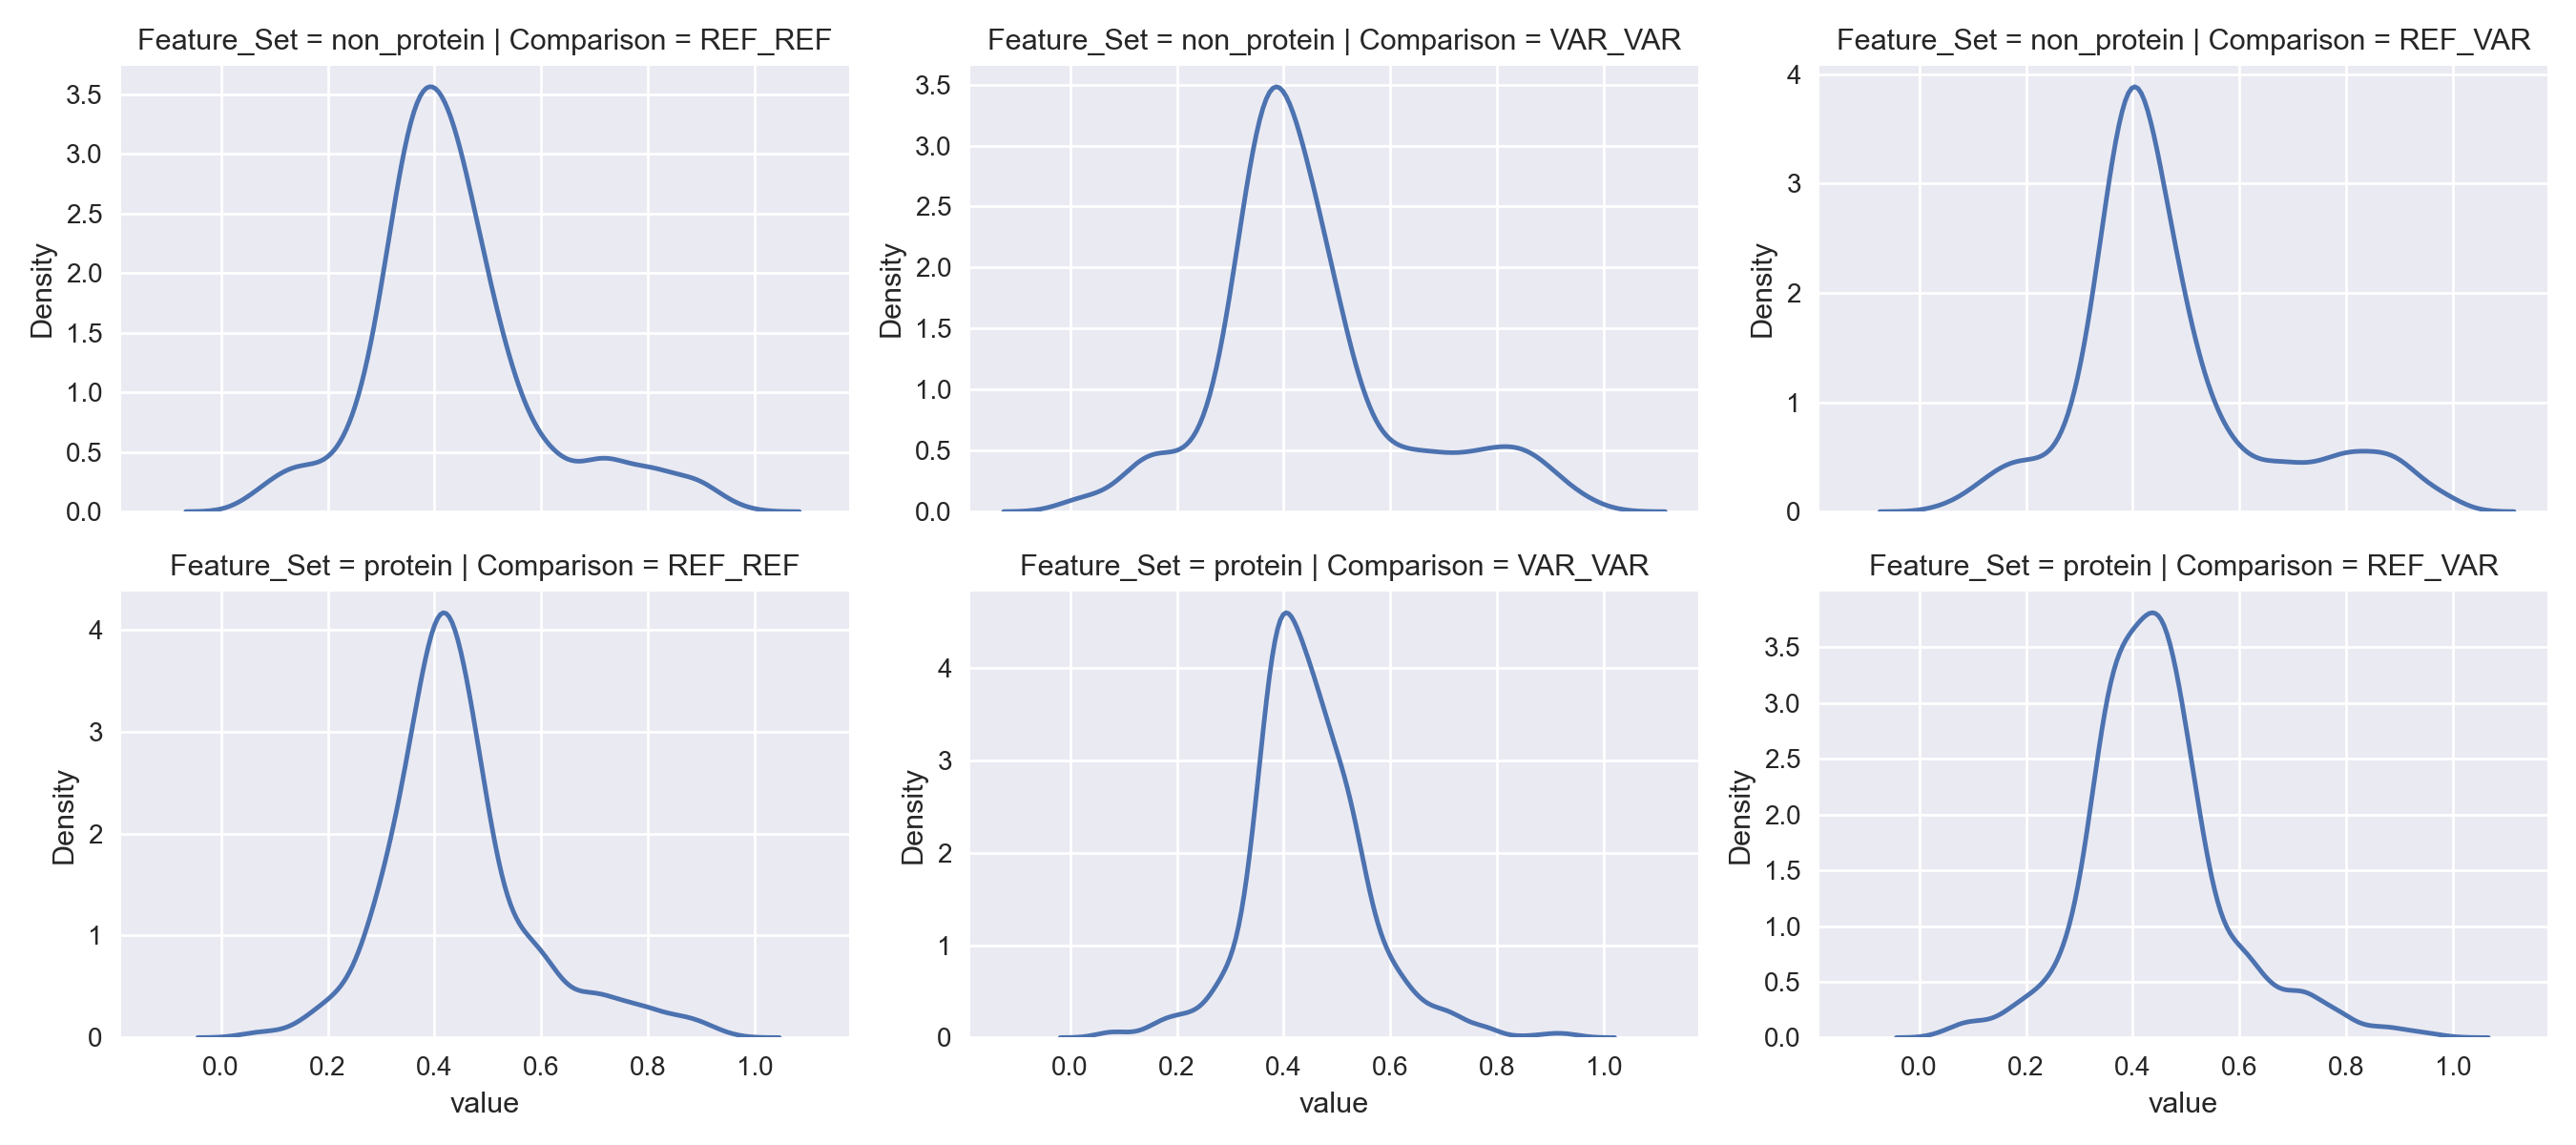

In [50]:
# plot F1 scores, faceted by Feature Set and Comparison

plt.style.use('seaborn')

g = sns.FacetGrid(f1_score.filter(pl.col("variable") == "F1_Score").to_pandas(), row='Feature_Set', col='Comparison', aspect=1.5, sharey=False)
g.map(sns.kdeplot, 'value')

plt.show()

In [51]:
# Read in all variable feature importance scores

comparisons = ['REF_control_feat_importance', 'VAR_control_feat_importance', 'feat_importance']
comp_dict = {'REF_control_feat_importance': 'REF_REF',
             'VAR_control_feat_importance': 'VAR_VAR',
             'feat_importance': 'REF_VAR'}

feat_imp = pl.DataFrame()
for fs in feature_sets:
    for comp in comparisons:
        
        df = pl.read_csv(f'{result_dir}/{batch}_{fs}_{comp}_normalized_feature_selected.csv')
        
        if "Reference_Well" in df.columns:
            df = df.rename({"Reference_Well": "Well_One", "Variant_Well": "Well_Two"})
            
        df = df.melt(id_vars = ['Well_One', 'Well_Two']).with_columns(pl.lit(fs).alias("Feature_Set"),
                                                                      pl.lit(comp_dict[comp]).alias('Comparison'),
                                                                      pl.lit(batch).alias('Batch'))
        feat_imp = pl.concat([feat_imp, df], how = "vertical")

In [52]:
# Add unique identifier
feat_imp = feat_imp.with_columns(pl.concat_str([pl.col("Well_One"), pl.col("Well_Two"), pl.col("Feature_Set"), pl.col("Comparison")], separator="_").alias("ClassifierID"))

# Add rank of feature within each classifier
feat_imp = feat_imp.with_columns(pl.col("value").rank(descending=True).over("ClassifierID").alias("FIP_rank"))

In [53]:
# summarize ranks

imp_summary = feat_imp.group_by(["variable", "Feature_Set", "Comparison"]).agg(pl.col("FIP_rank").mean().alias("mean_VIP"))

In [54]:
# Do features have similar importance across comparisons?

prot_summary = imp_summary.filter(pl.col("Feature_Set") == "protein").pivot(index="variable", columns="Comparison", values="mean_VIP")


In [55]:
cor_ref_var = stats.pearsonr(prot_summary[["REF_REF"]].to_series(), prot_summary[["VAR_VAR"]].to_series())
cor_ref_diff = stats.pearsonr(prot_summary[["REF_REF"]].to_series(), prot_summary[["REF_VAR"]].to_series())
cor_diff_var = stats.pearsonr(prot_summary[["REF_VAR"]].to_series(), prot_summary[["VAR_VAR"]].to_series())

In [56]:
print(cor_ref_var)
print(cor_ref_diff)
print(cor_diff_var)

PearsonRResult(statistic=0.9692525705580495, pvalue=1.4530241258349486e-161)
PearsonRResult(statistic=0.9877006710977805, pvalue=3.598759369689106e-213)
PearsonRResult(statistic=0.973831572901413, pvalue=1.3130816723382719e-170)


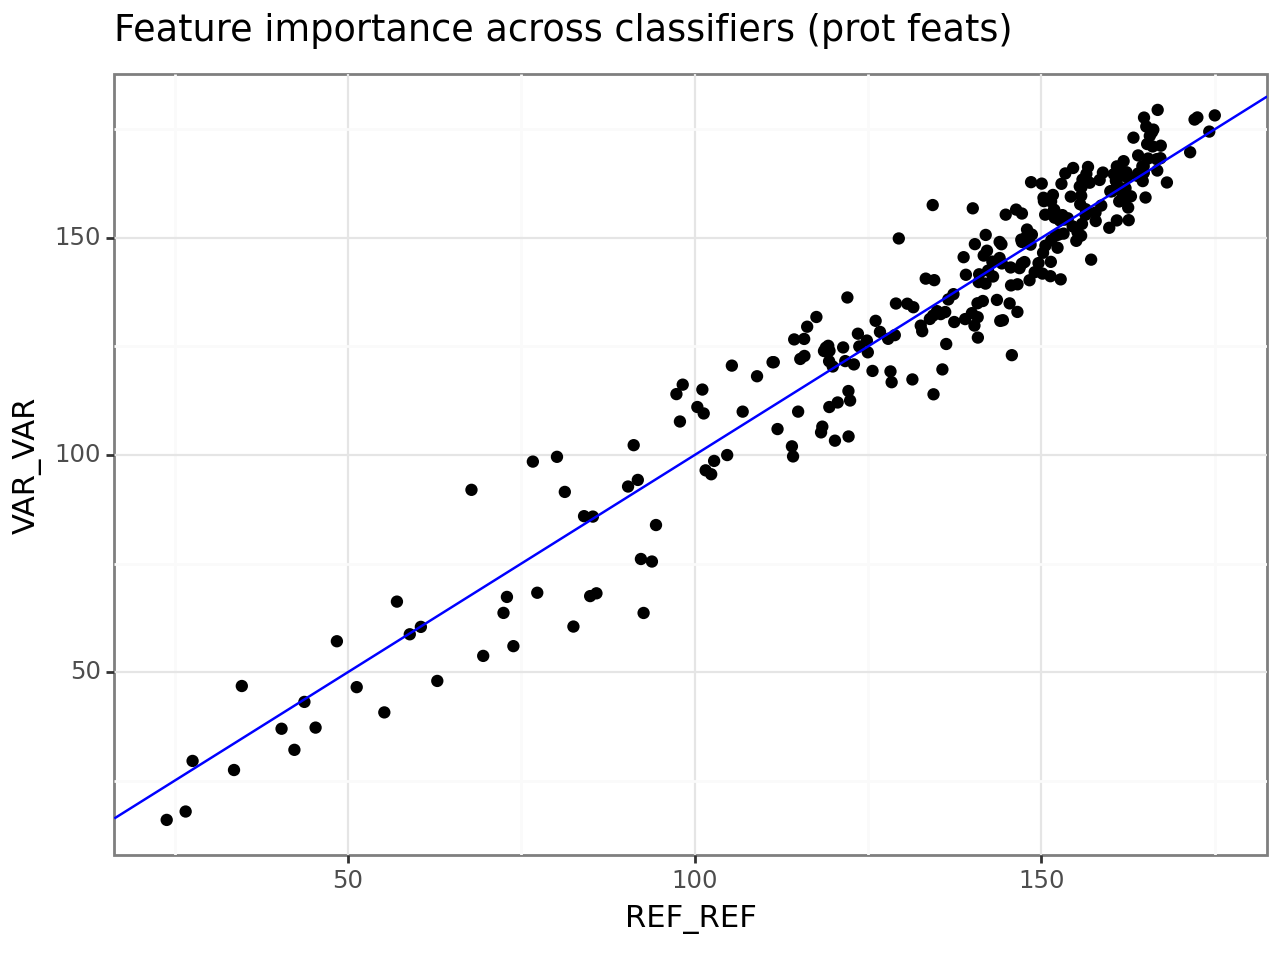

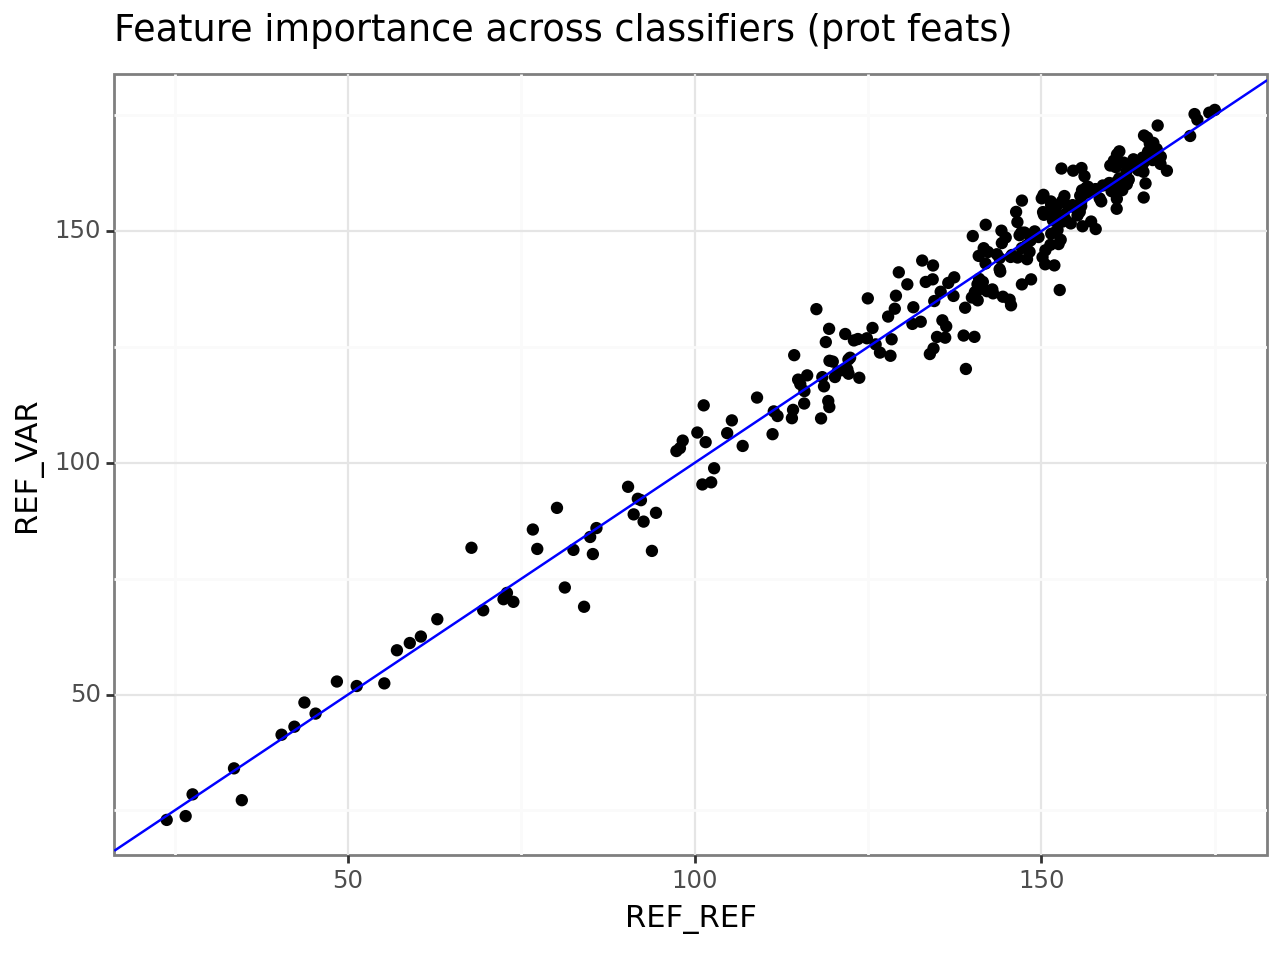

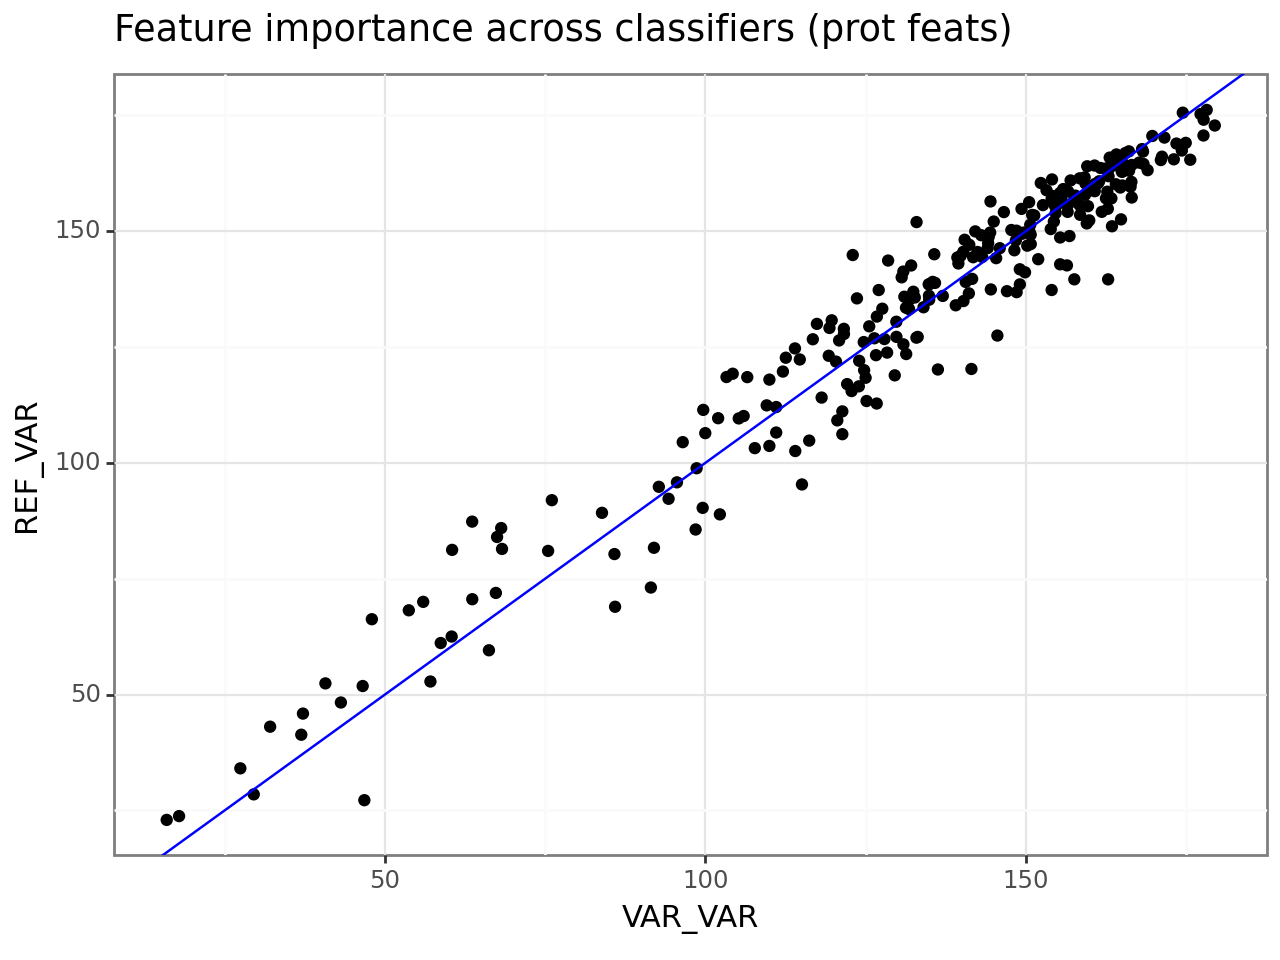

In [57]:
from plotnine import ggplot, aes, geom_point, theme_bw, geom_abline, ggtitle
p1 = (ggplot(prot_summary)
         + aes(x = "REF_REF", y = "VAR_VAR")
         + geom_point() + geom_abline(slope=1, intercept = 0, colour = 'blue') 
         + ggtitle("Feature importance across classifiers (prot feats)")
         + theme_bw())
print(p1)

p2 = (ggplot(prot_summary)
         + aes(x = "REF_REF", y = "REF_VAR")
         + geom_point() + geom_abline(slope=1, intercept = 0, colour = 'blue') 
         + ggtitle("Feature importance across classifiers (prot feats)")
         + theme_bw())
print(p2)

p3 = (ggplot(prot_summary)
         + aes(x = "VAR_VAR", y = "REF_VAR")
         + geom_point() + geom_abline(slope=1, intercept = 0, colour = 'blue') 
         + ggtitle("Feature importance across classifiers (prot feats)")
         + theme_bw())
print(p3)

In [58]:
# Now the same for non-protein features
nonprot_summary = imp_summary.filter(pl.col("Feature_Set") == "non_protein").pivot(index="variable", columns="Comparison", values="mean_VIP")

cor_ref_var = stats.pearsonr(nonprot_summary[["REF_REF"]].to_series(), nonprot_summary[["VAR_VAR"]].to_series())
cor_ref_diff = stats.pearsonr(nonprot_summary[["REF_REF"]].to_series(), nonprot_summary[["REF_VAR"]].to_series())
cor_diff_var = stats.pearsonr(nonprot_summary[["REF_VAR"]].to_series(), nonprot_summary[["VAR_VAR"]].to_series())

print(cor_ref_var)
print(cor_ref_diff)
print(cor_diff_var)


PearsonRResult(statistic=0.9851463513398824, pvalue=0.0)
PearsonRResult(statistic=0.990267352001724, pvalue=0.0)
PearsonRResult(statistic=0.9887945855687306, pvalue=0.0)


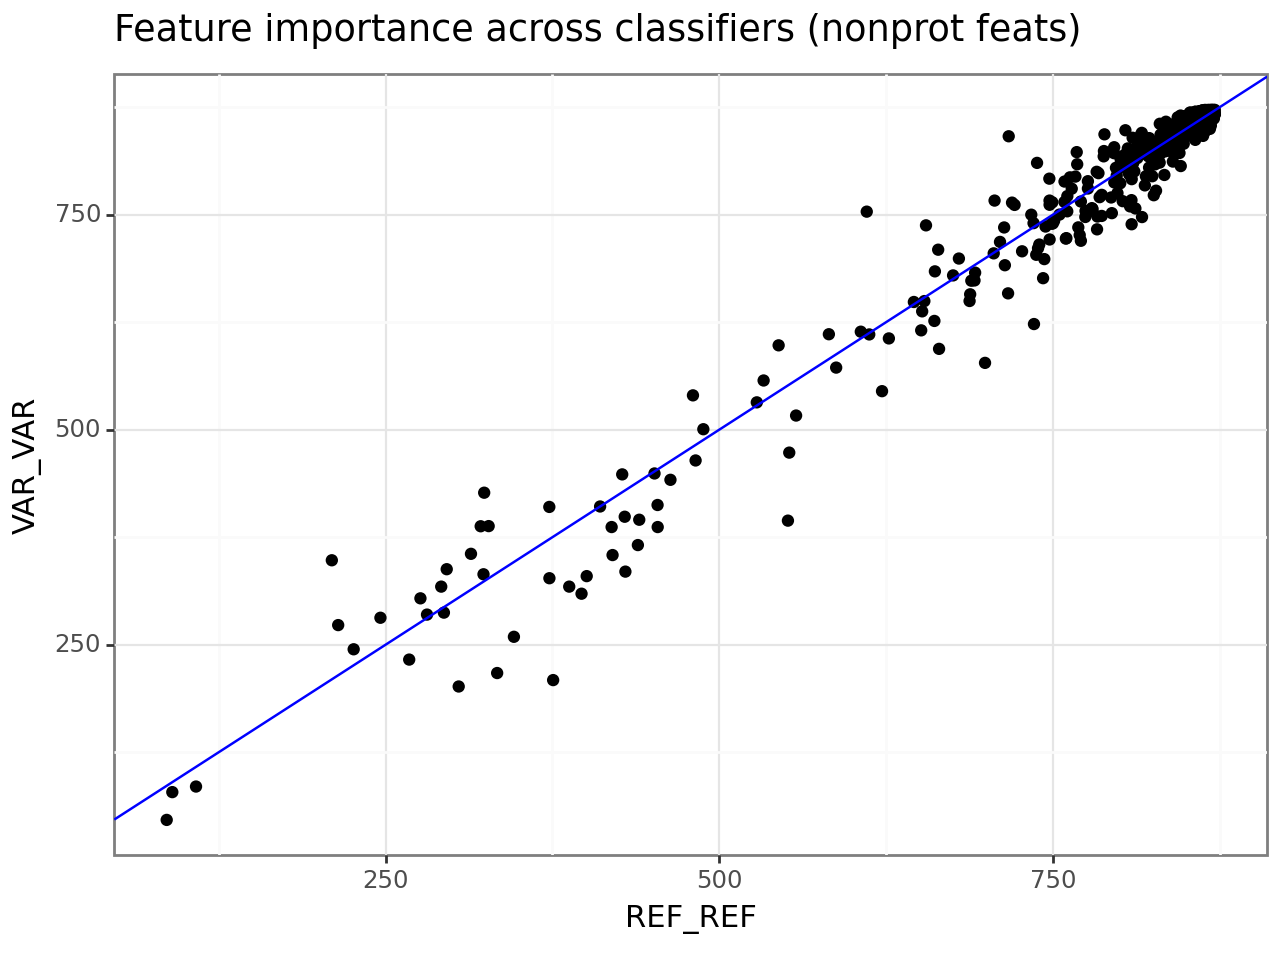

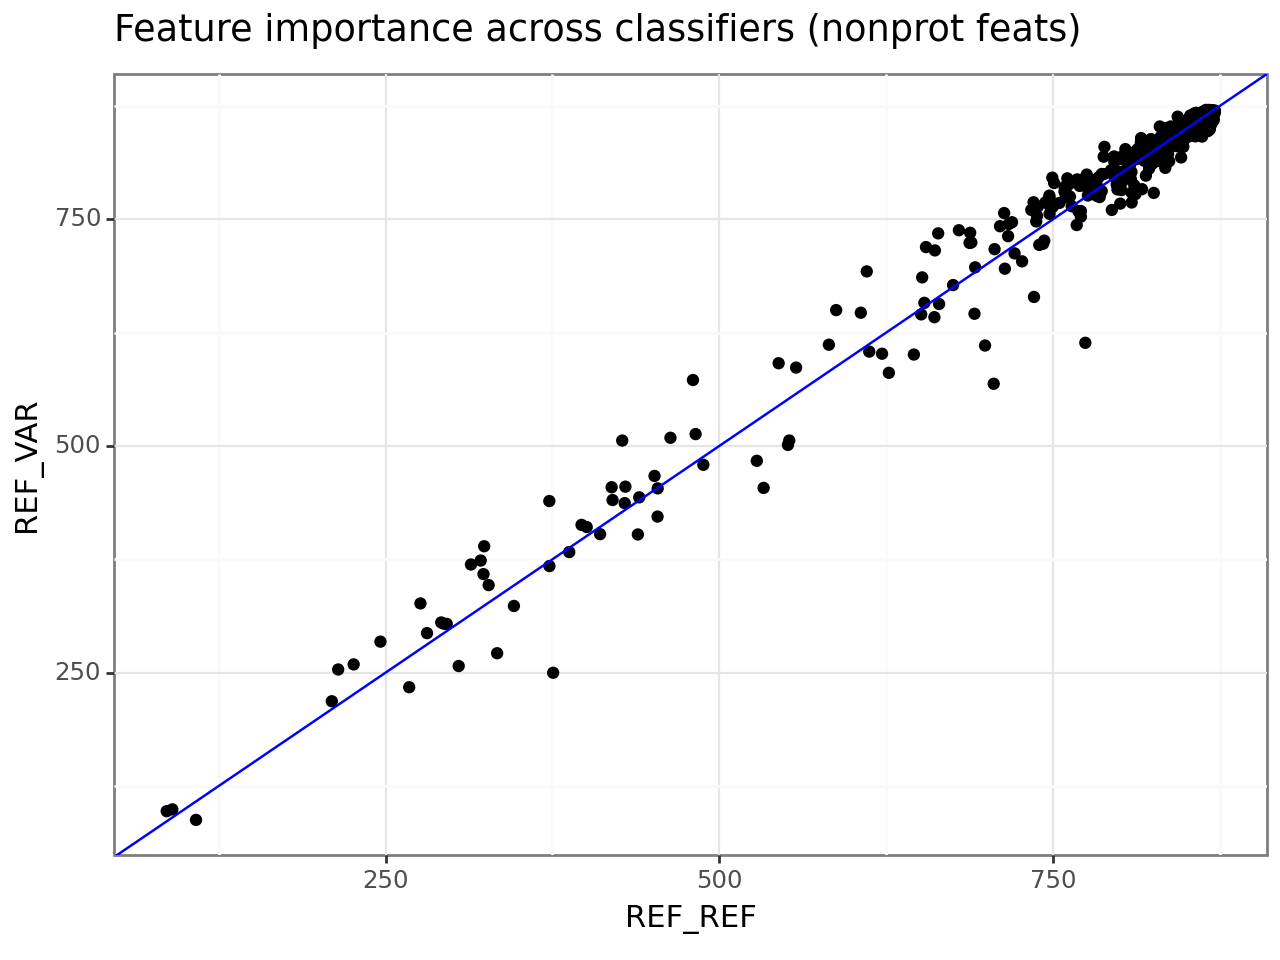

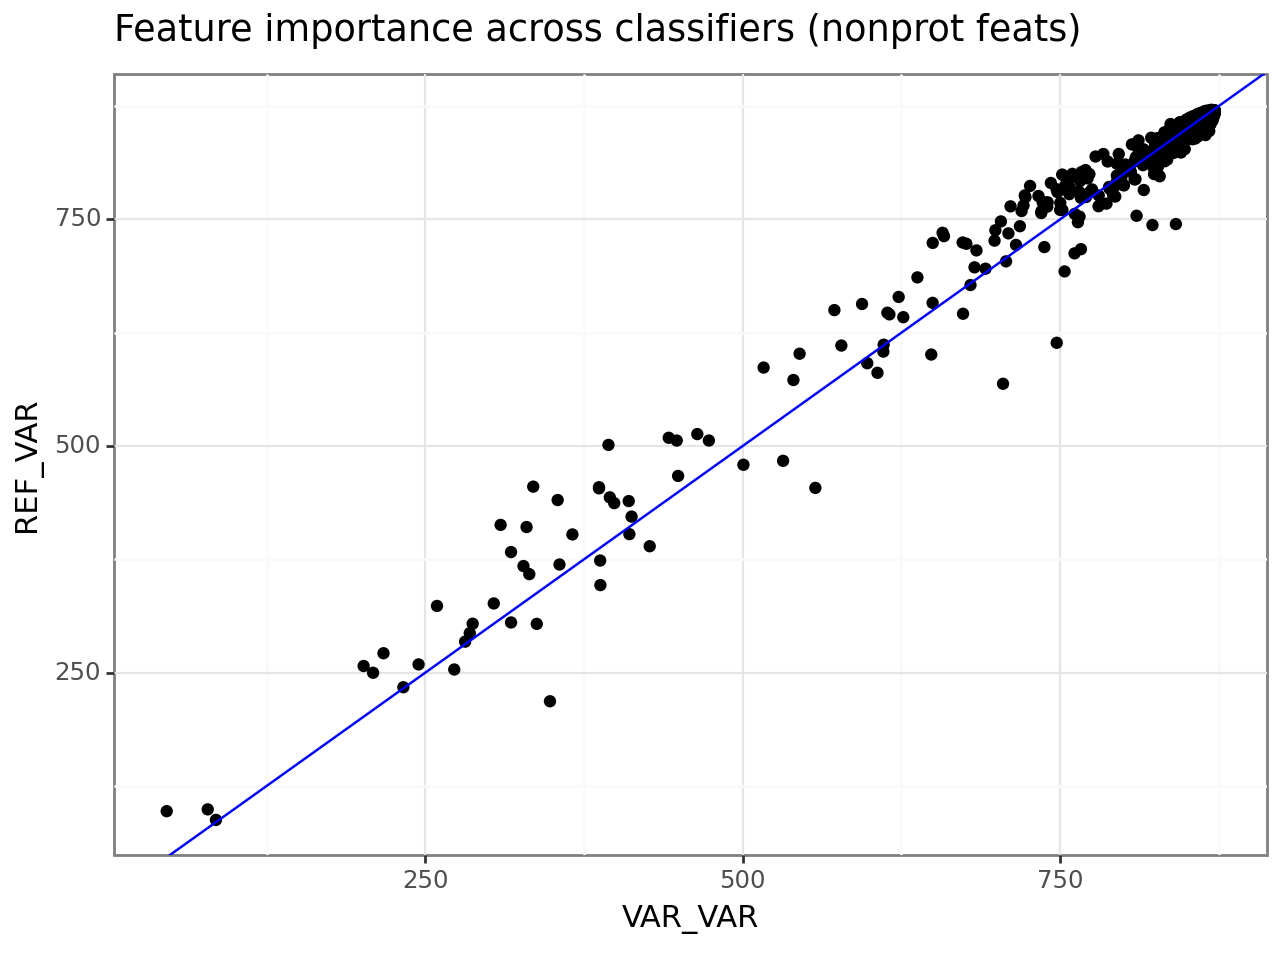

In [59]:
from plotnine import ggplot, aes, geom_point, theme_bw, geom_abline, ggtitle
p1 = (ggplot(nonprot_summary)
         + aes(x = "REF_REF", y = "VAR_VAR")
         + geom_point() + geom_abline(slope=1, intercept = 0, colour = 'blue') 
         + ggtitle("Feature importance across classifiers (nonprot feats)")
         + theme_bw())
print(p1)

p2 = (ggplot(nonprot_summary)
         + aes(x = "REF_REF", y = "REF_VAR")
         + geom_point() + geom_abline(slope=1, intercept = 0, colour = 'blue') 
         + ggtitle("Feature importance across classifiers (nonprot feats)")
         + theme_bw())
print(p2)

p3 = (ggplot(nonprot_summary)
         + aes(x = "VAR_VAR", y = "REF_VAR")
         + geom_point() + geom_abline(slope=1, intercept = 0, colour = 'blue') 
         + ggtitle("Feature importance across classifiers (nonprot feats)")
         + theme_bw())
print(p3)

Here, finally, we see a wider range of F1 scores but unfortunately the distributions are super consistent across different comparison types (REF-REF, VAR-VAR, REF-VAR). Next, analyze these scores to see if there is any spatial pattern across the plate.

In [68]:
f1_score = f1_score.filter(pl.col("variable") == "F1_Score")


In [69]:

# Convert well name into row and column coordinates
f1_score =f1_score.with_columns(pl.col("Well_One").str.slice(0,1).alias("Well_One_Letter"),
                                pl.col("Well_One").str.slice(1).cast(pl.Int64).alias("Well_One_Col"),
                                pl.col("Well_Two").str.slice(0,1).alias("Well_Two_Letter"),
                                pl.col("Well_Two").str.slice(1).cast(pl.Int64).alias("Well_Two_Col"))

letter_dict = {"A":1, "B":2, "C":3, "D":4, "E":5, "F":6, "G":7, "H":8, "I":9, "J":10, "K":11, "L":12, "M":13, "N":14, "O":15, "P":16}

f1_score = f1_score.with_columns(pl.Series(name="Well_One_Row", values=[letter_dict[val] for val in f1_score.select(pl.col("Well_One_Letter")).to_series()]),
                                 pl.Series(name="Well_Two_Row", values=[letter_dict[val] for val in f1_score.select(pl.col("Well_Two_Letter")).to_series()]))

In [70]:
# Compute physical distance between pairs of wells
import math

phys_dist = []
for row in f1_score.rows(named=True):
    phys_dist.append(math.dist([row['Well_One_Row'], row['Well_One_Col']], [row['Well_Two_Row'], row['Well_Two_Col']]))
 

In [74]:
dists = f1_score.with_columns(pl.Series(name="Phys_dist", values=phys_dist),
                              pl.concat_str([pl.col("Well_One"), pl.col("Well_Two")], separator="-").alias("Well_Pair"))

In [76]:
# Compute correlation between cosine similarity and physical distance
dist_cor = dists.group_by(["Comparison", "Feature_Set"]).agg(pl.corr("value", "Phys_dist").alias("Cor_F1_Dist"))

No correlation at all between physical distance and F1 score. 

In [ ]:
# New things to do:

# Train on 3, test on 4
# Shuffle one set of labels (for REF-REF) in scenario 2

In [77]:
dat = pl.scan_parquet("/dgx1nas1/storage/data/jess/varchamp/sc_data/processed_profiles/Rep_Ctrls/annotated_normalized_featselected.parquet").select(["Metadata_Plate", "Metadata_Batch"]).collect().unique()

In [79]:
dat.head

<bound method DataFrame.head of shape: (8, 2)
┌────────────────────────┬────────────────┐
│ Metadata_Plate         ┆ Metadata_Batch │
│ ---                    ┆ ---            │
│ str                    ┆ i64            │
╞════════════════════════╪════════════════╡
│ 2023-12-21_B6A3R2_P1T1 ┆ 6              │
│ 2023-12-21_B6A3R2_P1T4 ┆ 6              │
│ 2023-12-15_B4A3R1_P1T2 ┆ 4              │
│ 2023-12-18_B4A3R1_P1T3 ┆ 4              │
│ 2023-12-15_B4A3R1_P1T1 ┆ 4              │
│ 2023-12-21_B6A3R2_P1T2 ┆ 6              │
│ 2023-12-18_B4A3R1_P1T4 ┆ 4              │
│ 2023-12-21_B6A3R2_P1T3 ┆ 6              │
└────────────────────────┴────────────────┘>